# R: Ensemble Learners and More with `mlr3pipelines`

This notebook illustrates how to exploit the powerful tools provided by the [mlr3pipelines](https://mlr3pipelines.mlr-org.com/) package (Binder et al. 2021). For example, [mlr3pipelines](https://mlr3pipelines.mlr-org.com/) can be used in combination with [DoubleML](https://docs.doubleml.org/stable/index.html) for feature engineering, combination of learners (ensemble learners, stacking), subsampling and hyperparameter tuning. The underlying idea of [mlr3pipelines](https://mlr3pipelines.mlr-org.com/) is to define a pipeline that incorporates a user's desired operations. As a result, the pipeline returns an object of class [Learner](https://mlr3.mlr-org.com/reference/Learner.html) which can easily be passed to [DoubleML](https://docs.doubleml.org/stable/index.html). For an introduction to [mlr3pipelines](https://mlr3pipelines.mlr-org.com/), we refer to the [Pipelines Chapter](https://mlr3book.mlr-org.com/pipelines.html) in the [mlr3book](https://mlr3book.mlr-org.com) (Becker et al. 2020) and to the [package website](https://mlr3pipelines.mlr-org.com/).


We intend to illustrate the major idea of how to use [mlr3pipelines](https://mlr3pipelines.mlr-org.com/) in combination with [DoubleML](https://docs.doubleml.org/stable/index.html) in very simple examples. We use pipelines that are identical or very similar to the ones in the [Pipelines Chapter](https://mlr3book.mlr-org.com/pipelines.html) in the [mlr3book](https://mlr3book.mlr-org.com). Hence, we do not claim that the proposed learners are optimal in terms of their performance.

We start with the simple simulated data example and the [Bonus data set](https://docs.doubleml.org/r/stable/reference/fetch_bonus.html) from the [Getting Started Section in the DoubleML user guide](https://docs.doubleml.org/dev/intro/intro.html).

In [1]:
library(DoubleML)

# Simulate data
set.seed(3141)
n_obs = 500
n_vars = 100
theta = 3
X = matrix(rnorm(n_obs*n_vars), nrow=n_obs, ncol=n_vars)
d = X[,1:3]%*%c(5,5,5) + rnorm(n_obs)
y = theta*d + X[, 1:3]%*%c(5,5,5) + rnorm(n_obs)


# Specify the data and variables for the causal model
# matrix interface to DoubleMLData
dml_data_sim = double_ml_data_from_matrix(X=X, y=y, d=d)
dml_data_sim

================= DoubleMLData Object ==================


------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): d
Covariates: X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, X16, X17, X18, X19, X20, X21, X22, X23, X24, X25, X26, X27, X28, X29, X30, X31, X32, X33, X34, X35, X36, X37, X38, X39, X40, X41, X42, X43, X44, X45, X46, X47, X48, X49, X50, X51, X52, X53, X54, X55, X56, X57, X58, X59, X60, X61, X62, X63, X64, X65, X66, X67, X68, X69, X70, X71, X72, X73, X74, X75, X76, X77, X78, X79, X80, X81, X82, X83, X84, X85, X86, X87, X88, X89, X90, X91, X92, X93, X94, X95, X96, X97, X98, X99, X100
Instrument(s): 
No. Observations: 500

To have an example with a classification learner, we load the [Bonus data set](https://docs.doubleml.org/r/stable/reference/fetch_bonus.html).

In [2]:
# Load bonus data
df_bonus = fetch_bonus(return_type="data.table")
head(df_bonus)

# Specify the data and variables for the causal model
x_vars = c("female", "black", "othrace", "dep1", "dep2",
           "q2", "q3", "q4", "q5", "q6", "agelt35", "agegt54",
           "durable", "lusd", "husd")
dim_x = length(x_vars)
dml_data_bonus = DoubleMLData$new(df_bonus,
                             y_col = "inuidur1",
                             d_cols = "tg",
                             x_cols = x_vars)
print(dml_data_bonus)

inuidur1,female,black,othrace,dep1,dep2,q2,q3,q4,q5,q6,agelt35,agegt54,durable,lusd,husd,tg
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2.890372,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
0.000000,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3.295837,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2.197225,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
3.295837,0,0,0,1,0,0,0,0,1,0,0,1,1,1,0,0
3.295837,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0


================= DoubleMLData Object ==================


------------------ Data summary      ------------------
Outcome variable: inuidur1
Treatment variable(s): tg
Covariates: female, black, othrace, dep1, dep2, q2, q3, q4, q5, q6, agelt35, agegt54, durable, lusd, husd
Instrument(s): 
No. Observations: 5099


To specify a learner for the nuisance part in a causal model, we can either use [mlr3](https://mlr3.mlr-org.com/)'s [LearnerRegr](https://mlr3.mlr-org.com/reference/LearnerRegr.html) for a model's nuisance part with a continuous dependent variable or a [LearnerClassif](https://mlr3.mlr-org.com/reference/LearnerClassif.html) if the corresponding outcome variable is binary. 

Moreover, it's possible to create a learner based on a pipeline. For example, we could think of [ensemble learners](https://mlr3book.mlr-org.com/pipelines.html#pipe-model-ensembles) which combine several estimators.

## Using learners from `mlr3`, `mlr3learners` and `mlr3extralearners`

Let's begin with a "standard" example on how to use any of the learners provided by [mlr3](https://mlr3.mlr-org.com/) (Lang et al. 2020), [mlr3learners](https://mlr3learners.mlr-org.com/) (Lang et al. 2021) and [mlr3extralearners](https://mlr3extralearners.mlr-org.com/) (Sonabend and Schratz 2021) in [DoubleML](https://docs.doubleml.org/stable/index.html): We create an object of the class [Learner](https://mlr3.mlr-org.com/reference/Learner.html) which [DoubleML](https://docs.doubleml.org/stable/index.html) internally uses for model training and generation of predictions. 

In the simulated example, we will use a lasso estimator for the continuous treatment variable, which is based on the [glmnet package](https://glmnet.stanford.edu/index.html).  For the binary treatment variable in the Bonus data example, we use a random forest classifier as provided by [ranger](https://github.com/imbs-hl/ranger).

In [3]:
library(mlr3)
library(mlr3learners)

# suppress messages during fitting
lgr::get_logger("mlr3")$set_threshold("warn")

learner_lasso = lrn("regr.cv_glmnet", s="lambda.min")
ml_g_lasso = learner_lasso$clone()
ml_m_lasso = learner_lasso$clone()
class(ml_g_lasso)

[1] "LearnerRegrCVGlmnet" "LearnerRegr"         "Learner"            
[4] "R6"

In [4]:
# Random forest learner for nuisance part ml_g
learner_forest_regr = lrn("regr.ranger",
                          num.trees=500, mtry=floor(sqrt(dim_x)),
                          max.depth=5, min.node.size=2)

# Random forest learner for nuisance part ml_m (binary outcome)
learner_forest_classif = lrn("classif.ranger",
                             num.trees=500,
                             mtry=floor(sqrt(dim_x)),
                             max.depth=5, min.node.size=2)

ml_g_forest = learner_forest_regr$clone()
ml_m_forest = learner_forest_classif$clone()
class(ml_g_forest)

[1] "LearnerRegrRanger" "LearnerRegr"       "Learner"          
[4] "R6"

We set up a causal model, here we specify a partially linear model and thereby pass the learner as an input. Let's fit the models.

In [5]:
set.seed(123)
obj_dml_plr_sim = DoubleMLPLR$new(dml_data_sim,
                                  ml_g=ml_g_lasso,
                                  ml_m=ml_m_lasso)
obj_dml_plr_sim$fit()
print(obj_dml_plr_sim)

================= DoubleMLPLR Object ==================


------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): d
Covariates: X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, X16, X17, X18, X19, X20, X21, X22, X23, X24, X25, X26, X27, X28, X29, X30, X31, X32, X33, X34, X35, X36, X37, X38, X39, X40, X41, X42, X43, X44, X45, X46, X47, X48, X49, X50, X51, X52, X53, X54, X55, X56, X57, X58, X59, X60, X61, X62, X63, X64, X65, X66, X67, X68, X69, X70, X71, X72, X73, X74, X75, X76, X77, X78, X79, X80, X81, X82, X83, X84, X85, X86, X87, X88, X89, X90, X91, X92, X93, X94, X95, X96, X97, X98, X99, X100
Instrument(s): 
No. Observations: 500

------------------ Score & algorithm ------------------
Score function: partialling out
DML algorithm: dml2

------------------ Machine learner   ------------------
ml_g: regr.cv_glmnet
ml_m: regr.cv_glmnet

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample sp

In [6]:
set.seed(123)
obj_dml_plr_bonus = DoubleMLPLR$new(dml_data_bonus,
                                    ml_g=ml_g_forest,
                                    ml_m=ml_m_forest)
obj_dml_plr_bonus$fit()
print(obj_dml_plr_bonus)

================= DoubleMLPLR Object ==================


------------------ Data summary      ------------------
Outcome variable: inuidur1
Treatment variable(s): tg
Covariates: female, black, othrace, dep1, dep2, q2, q3, q4, q5, q6, agelt35, agegt54, durable, lusd, husd
Instrument(s): 
No. Observations: 5099

------------------ Score & algorithm ------------------
Score function: partialling out
DML algorithm: dml2

------------------ Machine learner   ------------------
ml_g: regr.ranger
ml_m: classif.ranger

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1
Apply cross-fitting: TRUE

------------------ Fit summary       ------------------
 Estimates and significance testing of the effect of target variables
   Estimate. Std. Error t value Pr(>|t|)  
tg   -0.0765     0.0354  -2.161   0.0307 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




## Set up learners based on `mlr3pipelines`

These learners can also be constructed using [mlr3pipelines](https://mlr3pipelines.mlr-org.com/). We'll first use the PipeOp constructor [po()](https://mlr3pipelines.mlr-org.com/reference/po.html) to define the learner construction and then initiate a new instance of the [Learner](https://mlr3.mlr-org.com/reference/Learner.html) class. [po()](https://mlr3pipelines.mlr-org.com/reference/po.html) implements a computational step in a pipeline. For more information, we refer to the [Pipelines Chapter in the mlr3book](https://mlr3book.mlr-org.com/pipelines.html#pipelines).

In [7]:
# Lasso learner
library(mlr3pipelines)
pipe_lasso = po(lrn("regr.cv_glmnet"), s = "lambda.min")
ml_g_lasso_pipe = as_learner(pipe_lasso)
ml_m_lasso_pipe = as_learner(pipe_lasso)

# Class of the lasso learner
class(ml_g_lasso_pipe)

[1] "GraphLearner" "Learner"      "R6"

In [8]:
# Random forest learner for nuisance part ml_g
pipe_forest_regr = po(lrn("regr.ranger"),
                      num.trees=500, mtry=floor(sqrt(dim_x)),
                      max.depth=5, min.node.size=2)

# Random forest learner for nuisance part ml_m (binary outcome)
pipe_forest_classif = po(lrn("classif.ranger"),
                             num.trees=500,
                             mtry=floor(sqrt(dim_x)),
                             max.depth=5, min.node.size=2)

ml_g_forest_pipe = as_learner(pipe_forest_regr)
ml_m_forest_pipe = as_learner(pipe_forest_classif)

# Class of the random forest learners
class(ml_g_forest_pipe)
class(ml_m_forest_pipe)

[1] "GraphLearner" "Learner"      "R6"

[1] "GraphLearner" "Learner"      "R6"

Let's use these learners to fit the PLR in both examples.

In [9]:
set.seed(123)
obj_dml_plr_sim_pipe = DoubleMLPLR$new(dml_data_sim,
                                       ml_g=ml_g_lasso_pipe,
                                       ml_m=ml_m_lasso_pipe)
obj_dml_plr_sim_pipe$fit()
print(obj_dml_plr_sim_pipe)

================= DoubleMLPLR Object ==================


------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): d
Covariates: X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, X16, X17, X18, X19, X20, X21, X22, X23, X24, X25, X26, X27, X28, X29, X30, X31, X32, X33, X34, X35, X36, X37, X38, X39, X40, X41, X42, X43, X44, X45, X46, X47, X48, X49, X50, X51, X52, X53, X54, X55, X56, X57, X58, X59, X60, X61, X62, X63, X64, X65, X66, X67, X68, X69, X70, X71, X72, X73, X74, X75, X76, X77, X78, X79, X80, X81, X82, X83, X84, X85, X86, X87, X88, X89, X90, X91, X92, X93, X94, X95, X96, X97, X98, X99, X100
Instrument(s): 
No. Observations: 500

------------------ Score & algorithm ------------------
Score function: partialling out
DML algorithm: dml2

------------------ Machine learner   ------------------
ml_g: regr.cv_glmnet
ml_m: regr.cv_glmnet

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample sp

In [10]:
set.seed(123)
obj_dml_plr_bonus_pipe = DoubleMLPLR$new(dml_data_bonus,
                                    ml_g=ml_g_forest_pipe,
                                    ml_m=ml_m_forest_pipe)
obj_dml_plr_bonus_pipe$fit()
print(obj_dml_plr_bonus_pipe)

================= DoubleMLPLR Object ==================


------------------ Data summary      ------------------
Outcome variable: inuidur1
Treatment variable(s): tg
Covariates: female, black, othrace, dep1, dep2, q2, q3, q4, q5, q6, agelt35, agegt54, durable, lusd, husd
Instrument(s): 
No. Observations: 5099

------------------ Score & algorithm ------------------
Score function: partialling out
DML algorithm: dml2

------------------ Machine learner   ------------------
ml_g: regr.ranger
ml_m: classif.ranger

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1
Apply cross-fitting: TRUE

------------------ Fit summary       ------------------
 Estimates and significance testing of the effect of target variables
   Estimate. Std. Error t value Pr(>|t|)  
tg   -0.0765     0.0354  -2.161   0.0307 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




## Use ensemble learners based on `mlr3pipelines`


First, let's see how we can use more complicated [GraphLearner](https://mlr3pipelines.mlr-org.com/reference/mlr_learners_graph.html)s like ensemble learners in [DoubleML](https://docs.doubleml.org/). For example, we want to create a learner with predictions that are generated as an average from three different learners. In the first step, we split up the pipeline into three branches. In our example, the learners estimate the nuisance parts independently of each other. In the last step, we average the predictions. Thereby we will use the pipe operator `%>>%`. For more details, we refer to the [Pipelines Chapter in the mlr3book](https://mlr3book.mlr-org.com/pipelines.html).

In [11]:
graph_ensemble = po("branch", c("lasso", "forest", "tree")) %>>%
  gunion(list(
    po("learner", lrn("regr.cv_glmnet", s = "lambda.min")),
    po("learner", lrn("regr.ranger")),
    po("learner", lrn("regr.rpart", cp = 0.01))
  )) %>>%
    po("unbranch", c("lasso", "forest", "tree")) %>>%
    po("regravg", 3)

In [12]:
# For regression (nuisance parts with continuous outcome)
graph_ensemble_regr = gunion(list(
    po("learner", lrn("regr.cv_glmnet", s = "lambda.min")),
    po("learner", lrn("regr.ranger")),
    po("learner", lrn("regr.rpart", cp = 0.01))
  )) %>>%
    po("regravg", 3)

# Class of ' graph_ensemble'
class(graph_ensemble)

[1] "Graph" "R6"

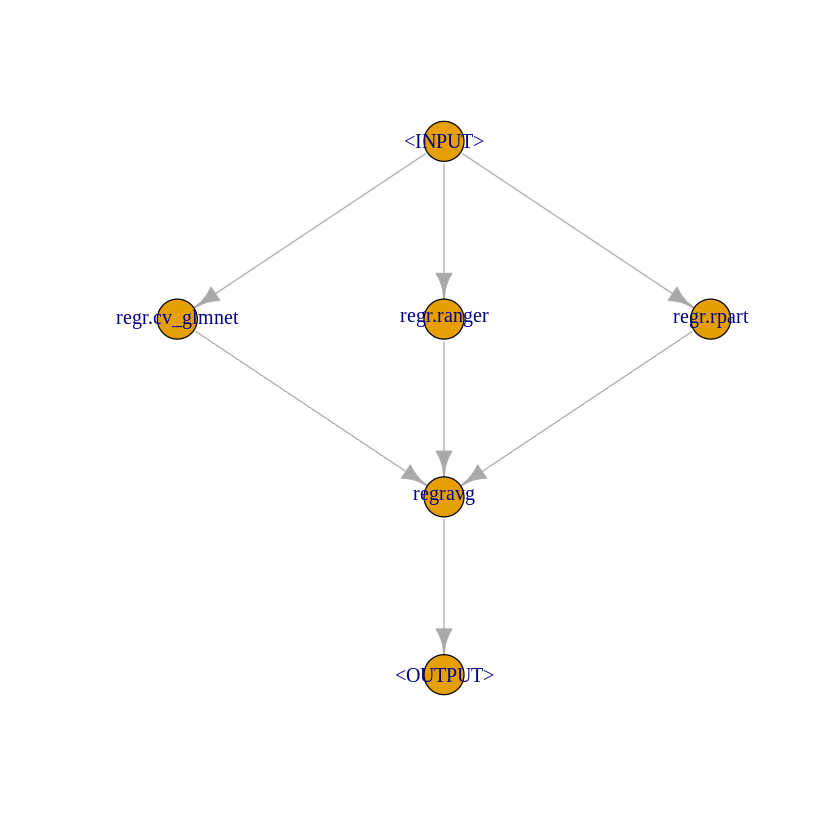

In [13]:
# Plot the graph
graph_ensemble_regr$plot()

In [14]:
# For classification (nuisance part ml_m in the Bonus example)
graph_ensemble_classif = gunion(list(
    po("learner", lrn("classif.cv_glmnet", s = "lambda.min")),
    po("learner", lrn("classif.ranger")),
    po("learner", lrn("classif.rpart", cp = 0.01))
  )) %>>%
    po("classifavg", 3)

# Class of 'graph_ensemble'
class(graph_ensemble_classif)

[1] "Graph" "R6"

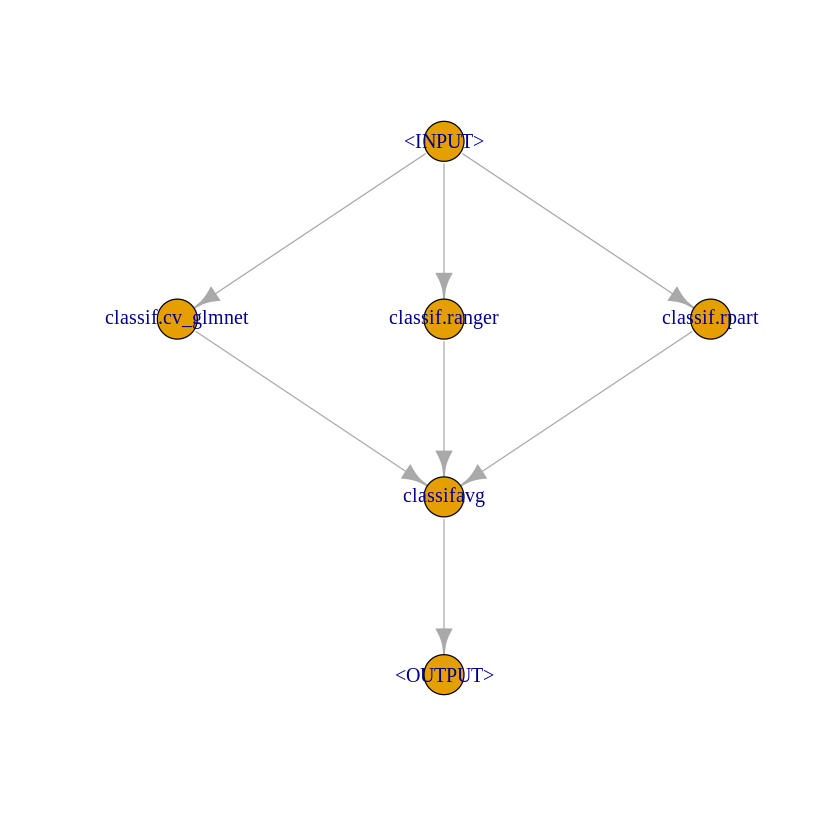

In [15]:
# Plot the graph
graph_ensemble_classif$plot()

We create a new instance of a [GraphLearner](https://mlr3pipelines.mlr-org.com/reference/mlr_learners_graph.html) which is later used in [DoubleML](https://docs.doubleml.org).

In [16]:
ensemble_pipe_regr = as_learner(graph_ensemble_regr)
ensemble_pipe_classif = as_learner(graph_ensemble_classif)

Let's estimate the two PLR examples with the ensemble learner.

In [17]:
# Initiate new DoubleML object and estimate with graph learner
set.seed(123)
obj_dml_plr_sim_pipe_ensemble = DoubleMLPLR$new(dml_data_sim,
                                                ml_g = ensemble_pipe_regr,
                                                ml_m = ensemble_pipe_regr)
obj_dml_plr_sim_pipe_ensemble$fit()
print(obj_dml_plr_sim_pipe_ensemble)

================= DoubleMLPLR Object ==================


------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): d
Covariates: X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, X16, X17, X18, X19, X20, X21, X22, X23, X24, X25, X26, X27, X28, X29, X30, X31, X32, X33, X34, X35, X36, X37, X38, X39, X40, X41, X42, X43, X44, X45, X46, X47, X48, X49, X50, X51, X52, X53, X54, X55, X56, X57, X58, X59, X60, X61, X62, X63, X64, X65, X66, X67, X68, X69, X70, X71, X72, X73, X74, X75, X76, X77, X78, X79, X80, X81, X82, X83, X84, X85, X86, X87, X88, X89, X90, X91, X92, X93, X94, X95, X96, X97, X98, X99, X100
Instrument(s): 
No. Observations: 500

------------------ Score & algorithm ------------------
Score function: partialling out
DML algorithm: dml2

------------------ Machine learner   ------------------
ml_g: regr.cv_glmnet.regr.ranger.regr.rpart.regravg
ml_m: regr.cv_glmnet.regr.ranger.regr.rpart.regravg

------------------ Resampling

In [18]:
set.seed(123)
obj_dml_plr_bonus_pipe_ensemble = DoubleMLPLR$new(dml_data_bonus,
                                    ml_g = ensemble_pipe_regr,
                                    ml_m = ensemble_pipe_classif)
obj_dml_plr_bonus_pipe_ensemble$fit()
print(obj_dml_plr_bonus_pipe_ensemble)

================= DoubleMLPLR Object ==================


------------------ Data summary      ------------------
Outcome variable: inuidur1
Treatment variable(s): tg
Covariates: female, black, othrace, dep1, dep2, q2, q3, q4, q5, q6, agelt35, agegt54, durable, lusd, husd
Instrument(s): 
No. Observations: 5099

------------------ Score & algorithm ------------------
Score function: partialling out
DML algorithm: dml2

------------------ Machine learner   ------------------
ml_g: regr.cv_glmnet.regr.ranger.regr.rpart.regravg
ml_m: classif.cv_glmnet.classif.ranger.classif.rpart.classifavg

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1
Apply cross-fitting: TRUE

------------------ Fit summary       ------------------
 Estimates and significance testing of the effect of target variables
   Estimate. Std. Error t value Pr(>|t|)  
tg  -0.07689    0.03545  -2.169   0.0301 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Alternatively, different learners could also be stacked. Here we simply repeat the example from the [Pipelines Chapter in the mlr3book](https://mlr3book.mlr-org.com/pipelines.html#pipe-model-ensembles-stacking) in our Bonus data example.

In [19]:
lrn = lrn("classif.rpart")
lrn_0 = po("learner_cv", lrn$clone())
lrn_0$id = "rpart_cv"

In [20]:
# Pass original features to final estimation step
level_0 = gunion(list(lrn_0, po("nop")))

In [21]:
combined = level_0 %>>% po("featureunion", 2)

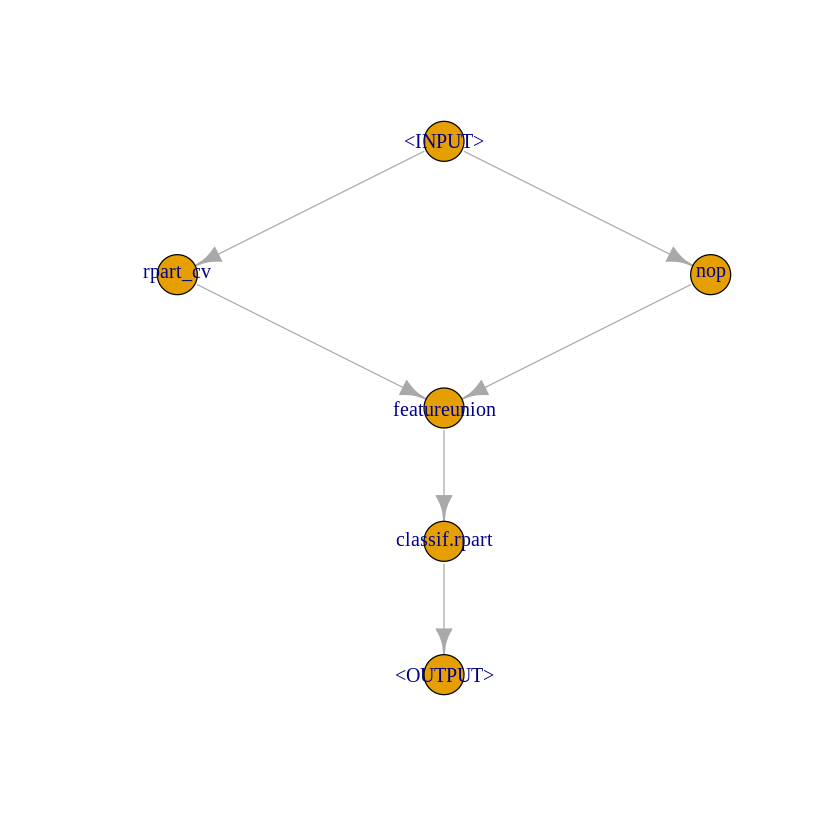

In [22]:
stack = combined %>>% po("learner", lrn$clone())
stack$plot(html = FALSE)

In [23]:
# Create a stacked learner and pass it to a DoubleML object
stacklrn = as_learner(stack)

set.seed(123)
obj_dml_plr_bonus_pipe = DoubleMLPLR$new(dml_data_bonus,
                                         ml_g=ml_g_forest,
                                         ml_m=stacklrn)
obj_dml_plr_bonus_pipe$fit()
print(obj_dml_plr_bonus_pipe)

================= DoubleMLPLR Object ==================


------------------ Data summary      ------------------
Outcome variable: inuidur1
Treatment variable(s): tg
Covariates: female, black, othrace, dep1, dep2, q2, q3, q4, q5, q6, agelt35, agegt54, durable, lusd, husd
Instrument(s): 
No. Observations: 5099

------------------ Score & algorithm ------------------
Score function: partialling out
DML algorithm: dml2

------------------ Machine learner   ------------------
ml_g: regr.ranger
ml_m: rpart_cv.nop.featureunion.classif.rpart

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1
Apply cross-fitting: TRUE

------------------ Fit summary       ------------------
 Estimates and significance testing of the effect of target variables
   Estimate. Std. Error t value Pr(>|t|)  
tg  -0.07915    0.03538  -2.237   0.0253 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




## How to exploit more features of `mlr3pipelines` in `DoubleML`

[mlr3pipelines](https://mlr3pipelines.mlr-org.com/reference/Graph.html) can do much more. For example, we could use it to perform some [feature engineering](https://mlr3book.mlr-org.com/pipelines.html#pipe-modeling) and even perform pipeline-based [parameter tuning](https://mlr3book.mlr-org.com/pipelines.html#pipe-tuning). We just have to define the steps we want to have in our pipeline by using the PipeOps.

Let's have a look at two more examples from the [Pipelines Chapter in the mlr3book](https://mlr3book.mlr-org.com/pipelines.html). In the first one, we will do some data manipulation. The second example illustrate how we could use [mlr3pipelines](https://mlr3pipelines.mlr-org.com/reference/Graph.html) for parameter tuning.

### Data preprocessing

Let's perform some data preprocessing and then use a regression tree for prediction.

In [24]:
mutate = po("mutate")
filter = po("filter",
    filter = mlr3filters::flt("variance"),
    param_vals = list(filter.frac = 0.5))

Collect them in a graph and plot it.

In [25]:
graph = mutate %>>%
  filter %>>%
  po("learner",
    learner = lrn("classif.rpart"))

class(graph)

[1] "Graph" "R6"

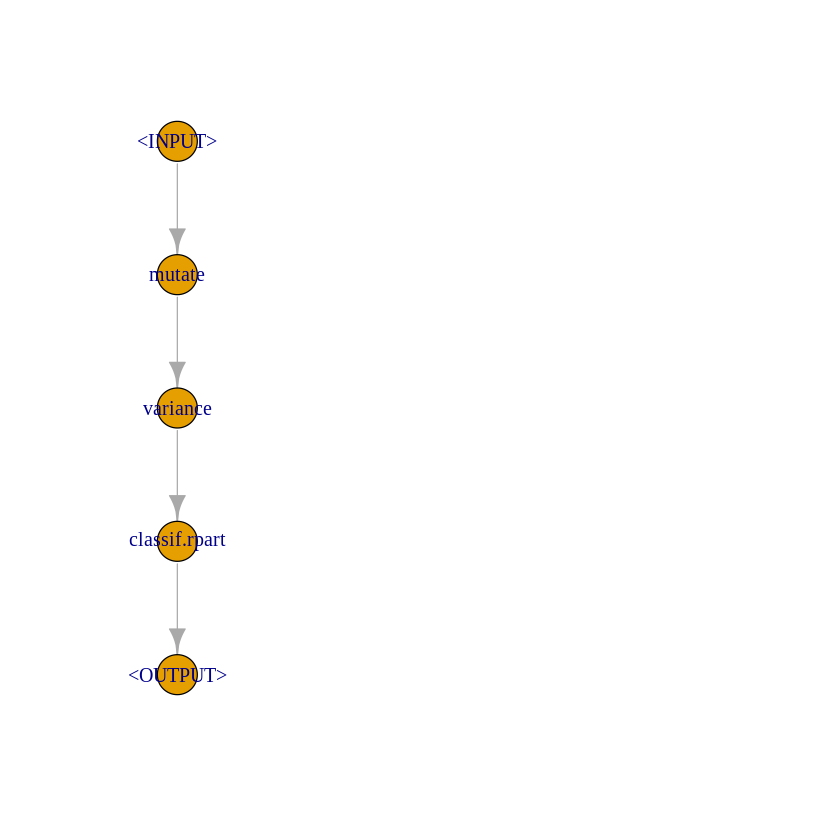

In [26]:
graph$plot()

Create a new learner.

In [27]:
glrn = as_learner(graph)

In [28]:
glrn
class(glrn)

<GraphLearner:mutate.variance.classif.rpart>
* Model: -
* Parameters: mutate.mutation=<list>, mutate.delete_originals=FALSE,
  variance.filter.frac=0.5, classif.rpart.xval=0
* Packages: mlr3, mlr3pipelines
* Predict Type: response
* Feature types: logical, integer, numeric, character, factor, ordered,
  POSIXct
* Properties: featureless, hotstart_backward, hotstart_forward,
  importance, loglik, missings, multiclass, oob_error,
  selected_features, twoclass, weights

[1] "GraphLearner" "Learner"      "R6"

In [29]:
set.seed(123)
obj_dml_plr_bonus_pipe2 = DoubleMLPLR$new(dml_data_bonus,
                                          ml_g=ml_g_lasso,
                                          ml_m=glrn)
obj_dml_plr_bonus_pipe2$fit()
print(obj_dml_plr_bonus_pipe2)

================= DoubleMLPLR Object ==================


------------------ Data summary      ------------------
Outcome variable: inuidur1
Treatment variable(s): tg
Covariates: female, black, othrace, dep1, dep2, q2, q3, q4, q5, q6, agelt35, agegt54, durable, lusd, husd
Instrument(s): 
No. Observations: 5099

------------------ Score & algorithm ------------------
Score function: partialling out
DML algorithm: dml2

------------------ Machine learner   ------------------
ml_g: regr.cv_glmnet
ml_m: mutate.variance.classif.rpart

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1
Apply cross-fitting: TRUE

------------------ Fit summary       ------------------
 Estimates and significance testing of the effect of target variables
   Estimate. Std. Error t value Pr(>|t|)  
tg  -0.07366    0.03539  -2.081   0.0374 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




Let's see how to set hyperparameters with a pipeline.

In [30]:
glrn$param_set$values$variance.filter.frac = 0.25

In [31]:
set.seed(123)
obj_dml_plr_bonus_pipe3 = DoubleMLPLR$new(dml_data_bonus,
                                          ml_g=ml_g_lasso,
                                          ml_m=glrn)
obj_dml_plr_bonus_pipe3$fit()
print(obj_dml_plr_bonus_pipe3)

================= DoubleMLPLR Object ==================


------------------ Data summary      ------------------
Outcome variable: inuidur1
Treatment variable(s): tg
Covariates: female, black, othrace, dep1, dep2, q2, q3, q4, q5, q6, agelt35, agegt54, durable, lusd, husd
Instrument(s): 
No. Observations: 5099

------------------ Score & algorithm ------------------
Score function: partialling out
DML algorithm: dml2

------------------ Machine learner   ------------------
ml_g: regr.cv_glmnet
ml_m: mutate.variance.classif.rpart

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1
Apply cross-fitting: TRUE

------------------ Fit summary       ------------------
 Estimates and significance testing of the effect of target variables
   Estimate. Std. Error t value Pr(>|t|)  
tg  -0.07366    0.03539  -2.081   0.0374 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




### Parameter tuning

Next, we will shortly illustrate how to perform parameter tuning in the simulated data example. Here, we use a pipeline to tune the penalty of the lasso. To do so, we generate a [GraphLearner](https://mlr3pipelines.mlr-org.com/reference/mlr_learners_graph.html) and then call [DoubleML](https://docs.doubleml.org)'s [tune()](https://docs.doubleml.org/r/stable/reference/DoubleML.html#method-tune) method.

Let's define a [GraphLearner](https://mlr3pipelines.mlr-org.com/reference/mlr_learners_graph.html) based on the lasso.

In [32]:
lasso_pipe = mutate %>>%
  filter %>>%
  po("learner",
    learner = lrn("regr.glmnet"))
glrn_lasso = as_learner(lasso_pipe)

Let's specify the parameter grid and more settings that are required for the parameter tuning. For more details, we refer to [the DoubleML user guide](https://docs.doubleml.org/stable/guide/learners.html#r-learners-and-hyperparameters). 

In [33]:
# Parameter grid for lambda and for optimal variance filter fraction
library(paradox)
par_grids = ps(regr.glmnet.lambda = p_dbl(lower = 0.05, upper = 0.1),
               variance.filter.frac = p_dbl(lower = 0.25, upper = 1))

In [34]:
# Specify further tune settings
library(mlr3tuning)
tune_settings = list(terminator = trm("evals", n_evals = 10),
                      algorithm = tnr("grid_search", resolution = 10),
                      rsmp_tune = rsmp("cv", folds = 5),
                      measure = list("ml_g" = msr("regr.mse"),
                                     "ml_m" = msr("regr.mse")))

In [35]:
# Initiate new DoubleML object and execute tuning with graph learner
set.seed(123)
obj_dml_plr_sim_pipe_tune = DoubleMLPLR$new(dml_data_sim,
                                            ml_g=glrn_lasso,
                                            ml_m=glrn_lasso)
obj_dml_plr_sim_pipe_tune$tune(param_set = list("ml_g" = par_grids,
                                                "ml_m" = par_grids),
                               tune_settings=tune_settings)

INFO  [09:39:02.284] [bbotk] Starting to optimize 2 parameter(s) with '<OptimizerGridSearch>' and '<TerminatorEvals> [n_evals=10, k=0]' 
INFO  [09:39:02.322] [bbotk] Evaluating 1 configuration(s) 
INFO  [09:39:03.233] [bbotk] Result of batch 1: 
INFO  [09:39:03.237] [bbotk]  regr.glmnet.lambda variance.filter.frac regr.mse runtime_learners 
INFO  [09:39:03.237] [bbotk]          0.07222222            0.6666667 107.2925            0.536 
INFO  [09:39:03.237] [bbotk]                                 uhash 
INFO  [09:39:03.237] [bbotk]  22e65ed8-7e85-4cd7-959a-35a59eb531f3 
INFO  [09:39:03.239] [bbotk] Evaluating 1 configuration(s) 
INFO  [09:39:04.129] [bbotk] Result of batch 2: 
INFO  [09:39:04.132] [bbotk]  regr.glmnet.lambda variance.filter.frac regr.mse runtime_learners 
INFO  [09:39:04.132] [bbotk]                 0.1            0.6666667 106.2652            0.527 
INFO  [09:39:04.132] [bbotk]                                 uhash 
INFO  [09:39:04.132] [bbotk]  178d0058-36ff-47fe-a20e

In [36]:
obj_dml_plr_sim_pipe$fit()
print(obj_dml_plr_sim_pipe)

================= DoubleMLPLR Object ==================


------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): d
Covariates: X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, X16, X17, X18, X19, X20, X21, X22, X23, X24, X25, X26, X27, X28, X29, X30, X31, X32, X33, X34, X35, X36, X37, X38, X39, X40, X41, X42, X43, X44, X45, X46, X47, X48, X49, X50, X51, X52, X53, X54, X55, X56, X57, X58, X59, X60, X61, X62, X63, X64, X65, X66, X67, X68, X69, X70, X71, X72, X73, X74, X75, X76, X77, X78, X79, X80, X81, X82, X83, X84, X85, X86, X87, X88, X89, X90, X91, X92, X93, X94, X95, X96, X97, X98, X99, X100
Instrument(s): 
No. Observations: 500

------------------ Score & algorithm ------------------
Score function: partialling out
DML algorithm: dml2

------------------ Machine learner   ------------------
ml_g: regr.cv_glmnet
ml_m: regr.cv_glmnet

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample sp

## References

Becker, M., Binder, M., Bischl, B., Lang, M., Pfisterer, F., Reich, N.G., Richter, J., Schratz, P., Sonabend, R. (2020), mlr3 book, available at https://mlr3book.mlr-org.com.

Binder, M., Pfisterer, F., Lang, M., Schneider, L., Kotthof, L., and Bischl, B. (2021), mlr3pipelines - flexible machine learning pipelines in R, Journal of Machine Learning Research, 22(184): 1-7, https://jmlr.org/papers/v22/21-0281.html.

Lang, M., Binder, M., Richter, J., Schratz, P., Pfisterer, F., Coors, S., Au, Q., Casalicchio, G., Kotthoff, L., Bischl, B. (2019), mlr3: A modern object-oriented machine learing framework in R. Journal of Open Source Software, [doi:10.21105/joss.01903](https://doi.org/10.21105/joss.01903).

Lang, M., Au, Q., Coors, S., and Schratz, P. (2021), mlr3learners: Recommended learners for mlr3, R package, https://CRAN.R-project.org/package=mlr3learners.

Sonabend, R., and Schratz, P. (2021), extralearners: Extra learners for mlr3. R package, https://mlr3extralearners.mlr-org.com/.

______

**Acknowledgement**

We would like to thank the developers of the [mlr3pipelines](https://mlr3pipelines.mlr-org.com/) package for providing such a powerful and easy-to-use implementation of many important ML tools.